**TO BE DONE**

- SPIEGARE LEISEN-REIDEN ALGORITHM
- VALUTARE SE INSERIRE ANCHE L'ALBERO BINOMIALE CON DIVIDENDI NON CONTINUI

# Pricing with Trees

First of all we import numpy and matplotlib under the names np and plt, respectively, as this is very common in the Python scientific computing community and a good programming habit.

In [208]:
%matplotlib inline

import math
import scipy
import numpy             as np
import pandas            as pd
import scipy.stats       as ss
import matplotlib
import pylab

from pylab import *
from matplotlib import pyplot as pl

# local module
from gdl_finance.analytic import BlackScholes
from gdl_finance.trees    import binomial_tree, trinomial_tree

## Binomial Tree for Option Pricing ##

### What is a binomial tree ###

The binomial pricing method is a simple and computationally fast method for pricing
vanilla options. 

With this method, you create **a tree of possible price outcomes of the underlying asset**. To do this you start with the current spot price of the underlying asset. From this, you create two branches, one with the expected price in the next period in an upstate and the other for the expected price in a downstate. These states are calculated by dividing the life of the option into a large numer of intervals $n$ of equal length $\Delta t$. 

At each period, the stock may move from the initial value $S$ to either up ($Su$) with probability p or down ($Sd$) with probability $q=1-p$. The interest rate is constant and is denoted by $r$. From each of these branches you will create two more branches by the same process. This process is repeated until the options expiry is reached, creating a price tree.

Let's start considering only one period to expiration, an hypothetical call option written on the asset will have at expiration the payoffs $c_u = \max[0, S_0u-K]$ if the stock price goes to $S_0u$ and $c_d= \max[0, S_0d-K]$ if the stocks decreases to $S_0d$.

If a portfolio can be constructed with a long position of $\Delta$ shares of the stock and a short position in the option, the value of our portfolio in the two states will be:

$$\Delta S_0u - c_u$$ 
$$\Delta S_0d - c_d$$

It is easy to find that if we choose $\Delta$ as 

\begin{equation}
  \Delta = \frac{C_u - C_d}{(u-d)S_0} \sim \frac{\partial C}{\partial S}
\end{equation}

our portfolio will have the same value in both states so it will be a *risk free* portfolio.

![caption](binomial_1.png)

To preclude the existence of arbitrage opportunities in the market the yield of our portfolio must be the risk free rate, so considering a unit interval we have

$$
P_T = e^{rT}P_0
$$

\begin{align}
&\frac{P_T}{P_0} = \frac{S_0 \Delta \cdot  u -c_u}{S_0 \Delta  - C} \> = e^{rT} \Rightarrow \notag\\
\Rightarrow C &= \frac{S_0 \Delta \cdot e^{rT} + c_u - u S_0 \Delta }{e^{rT}} \notag\\\
              &= \frac{S_0\Delta\cdot  (e^{rT}-u) + c_u}{e^{rT}}
\end{align}

and, using the value of $\Delta$ 

\begin{align}
C &= \frac{\frac{c_u-c_d}{u-d}(e^{rT}-u)+c_u}{e^{rT}}  \notag\\
  &= \frac{c_ue^{rT}-c_uu-c_de^{rT}+c_du+c_uu-c_ud}{e^{rT}(u-d}  \notag\\
  &= e^{-rT} \frac{c_u(e^{rT}-d) + c_d(u-e^{rT})}{(u-d)} \notag\\
  &= e^{-rT} \left[ c_u \frac{e^{rT}-d}{u-d} + c_d \frac{u-e^{rT}}{u-d} \right] \notag\\
  &= e^{-rT}\Bigl[ p\cdot c_u + (1-p) \cdot c_d \Bigr] 
\end{align}

where

\begin{equation}
  p \equiv \frac{e^{rT}-d}{u-d} \quad \quad 1-p \equiv \frac{u-e^{rT}}{u-d}
\end{equation}

$p$ if we assume $d \le r \le d$, $p$ is always greater than zero and less than one showing the basic properties of a probability measure.

### The Cox, Ross and Rubinstein Tree ###

With respect to the definition of $p$, $u$ and $d$ an important assumption about the behavior of the stochastic process of the underlying stock has to be done. In the following we'll follow the framework set up by Cox, Ross and Rubinstein. 

Let's assume that the stochastic process is continuous as $n \rightarrow \infty$. The parameters $p$, $u$ and $d$ must be chosen in a way to determine the right values of the stock expected return and variance at the end of each interval $\Delta t$. **Given the assumption of risk neutrality the one period expected return of the stock is equal to the risk free rate**

$$r \Delta t$$ 

and the expected future stock price is

\begin{equation}
        Se^{r\Delta t} =pSu + (1-p)Sd \Rightarrow  E_\pi \left[r\Delta t \right] =pu + (1-p)d
\end{equation}

and the variance of this return is given by

\begin{equation}
        \mathit{Var}\>(r \Delta t) = 
        E_\pi [(r\Delta t)^2] - [E_\pi(r \Delta t)]^2 = [pu^2 +(1-p)d^2] - [pu + (1-p)d]^2
\end{equation}

The Cox, Ross and Rubinstein binomial tree model assume that in the limit $n \rightarrow \infty$, the discrete process must converge to the ordinary Black and Scholes framework with a geometric brownian motion for the underlying stock price. So the idea is to find values for $u$ and $d$ in order to have

$$\mathit{Var}\>(r \Delta t) = \sigma^2 \Delta t$$

We need an additional assumption in order to obtain a tree that recombines, so that the effect of a down movement followed by an up movement is the same as the effect of an up movement, followed by a down movement.

\begin{equation}
        u=\frac{1}{d}
\end{equation}

With a bit of trivial algebra we find

\begin{align}
\mathit{Var}\>(r \Delta t) & = p u^2 +(1-p)d^2 - p^2u^2-(1-p)^2d^2 - 2p(1-p)ud \notag\\
&= pu^2 (1-p) + p(1-p)d^2 - 2p (1-p)ud \notag\\
&= p(1-p)(u^2+d^2-2ud) \notag\\
&= p(1-p)(u-d)^2 \notag\\
&= \frac{e^{r\Delta t}-d}{u-d} \Bigl[\frac{u-e^{r\Delta t}}{u-d}\Bigr] (u-d)^2 \notag\\
&= (e^{r\Delta t} -d)(u-e^{r\Delta t})  \notag\\
&= e^{r\Delta t}(u+d) -ud-e^{2r\Delta t}
\end{align}

from the last row, keeping the lower order terms we have

\begin{align}
\mathit{Var}\>(r \Delta t) &=
    e^{r\Delta t}(u+d) -ud-e^{2r\Delta t} \notag\\
    &\sim (1+r\Delta t)(u+d)-1-1-2r\Delta t \notag\\
    &= (1+r\Delta t)(u+d-2)
\end{align}

If we choose

\begin{equation}
u = e^{\sigma\sqrt{\Delta t}} , \quad \quad d = \frac{1}{u} = e^{-\sigma\sqrt{\Delta t}}
\end{equation}

up to the first order in $\Delta t$ we have

\begin{equation}
u \sim 1 + \sigma\sqrt{\Delta t} +\frac{1}{2}\sigma^2 \Delta t , \quad \quad d \sim 1-\sigma\sqrt{\Delta t}+\frac{1}{2}\sigma^2 \Delta t
\end{equation}

and finally

\begin{align}
\mathit{Var}\>(r \Delta t) &= 
(1+r\Delta t)(u+d-2) \notag\\
&\sim (1+r\Delta t)\Bigl(1 + \sigma\sqrt{\Delta t} +\frac{1}{2}\sigma^2 \Delta t
+1 - \sigma\sqrt{\Delta t} +\frac{1}{2}\sigma^2 \Delta t -2 \Bigr) \notag\\
&=(1+r\Delta t)\Bigl(\sigma^2 \Delta t \Bigr) \notag\\
&\sim \sigma^2 \Delta t + O\left({(\Delta t)^2} \right)
\end{align}

Ok, now the time has come to translate all this theory into python code. Let's start...

#### Implementing the Cox-Ross-Rubinstein Binomial Tree in Python ###

First of all, we define some functions for the analytical pricing of an european option according to the Black and Scholes model. The value of a call option for a non-dividend-paying underlying stock in terms of the Black–Scholes parameters is:

\begin{equation}
C(S_{t},t) =N(d_{1})S_{t}-N(d_{2})Ke^{-r(T-t)}
\end{equation}

\begin{equation}
d_{1} ={\frac {1}{\sigma {\sqrt {T-t}}}}\left[\ln \left({\frac {S_{t}}{K}}\right)+\left(r+{\frac {\sigma ^{2}}{2}}\right)(T-t)\right]
\end{equation}

\begin{equation}
d_{2} = d_{1}-\sigma {\sqrt {T-t}}
\end{equation}

The price of a corresponding put option based on put–call parity is:

\begin{align}
P(S_{t},t)&=Ke^{-r(T-t)}-S_{t}+C(S_{t},t) \notag\\
&=N(-d_{2})Ke^{-r(T-t)}-N(-d_{1})S_{t}
\end{align}

For both:

- $N(\cdot )$ is the cumulative distribution function of the standard normal distribution
- $T-t$ is the time to maturity (expressed in years)
- $S_{t}$ is the spot price of the underlying asset
- $K$ is the strike price
- $r$ is the risk free rate (annual rate, expressed in terms of continuous compounding)
- $\sigma$  is the volatility of returns of the underlying asset


**European Options**

In [209]:
def binomial_model_european(N, S0, sigma, r, K, Maturity, opt_type = 'put'):
    """
    N      = number of binomial levels
    S0     = initial stock price
    sigma  = factor change of upstate
    r      = risk free interest rate per annum
    K      = strike price
    """
    delta_t     = Maturity/float(N)
    discount    = exp(-r*delta_t)
    #
    # u and d values are chosen according to the CRR model
    #
    u = exp(sigma*sqrt(delta_t))
    d = 1 / u
    p = (exp(r*delta_t)- d) / (u - d)
    q = 1 - p
    #
    # make stock price tree
    # 
    stock = np.zeros([N + 1, N + 1])
    for i in range(N + 1):
        for j in range(i + 1):
            stock[j, i] = S0 * (u ** (i - j)) * (d ** j)
    #
    # Initialize option matrix 
    #
    option = np.zeros([N + 1, N + 1])
    # 
    # Generate option prices recursively
    #
    #
    # We start from the maturity (the binomial tree is a backward 
    # in time algorithm remember?). At maturity we know the value 
    # of the option in all states, it is simply the payoff. In this
    # case the payoff is that of a put option.
    #
    if opt_type == 'put':
        option[:, N] = np.maximum(np.zeros(N + 1), (K - stock[:, N]))
    else:
        option[:, N] = np.maximum(np.zeros(N + 1), (stock[:, N]) - K)
        
    for i in range(N - 1, -1, -1):
        for j in range(0, i + 1):
            option[j, i] = (
                discount * (p * option[j, i + 1] + q * option[j + 1, i + 1])
            )
    return [stock, option]

calculating example option price:

In [215]:
S0    = 101.15  # initial stock level
K     =  98.0   # strike price
T     =   1.0   # time-to-maturity
r     =   0.00  # short rate
sigma =   0.05  # volatility
delta =   0.0   # dividend yield

N     =   5

In [216]:
result = binomial_model_european(N, S0, sigma, r, K, T) 
print('Option price (binomial tree): ', round(result[1][0][0],3))
opt_bs = BlackScholes('P', S0, K, r, 0.0, sigma, T)
print('Option price (analytic)     : ', round(opt_bs,3))

Option price (binomial tree):  0.801
Option price (analytic)     :  0.796


The "topology" of the tree is described in the following picture

![caption](binomial_2.png)

In [217]:
if N <= 5:    
    print('Option Price Tree')
    print(result[1])

Option Price Tree
[[0.80067389 0.22299758 0.         0.         0.         0.        ]
 [0.         1.36557631 0.44106411 0.         0.         0.        ]
 [0.         0.         2.26964521 0.87237518 0.         0.        ]
 [0.         0.         0.         3.63601806 1.72545993 0.        ]
 [0.         0.         0.         0.         5.5043289  3.41276558]
 [0.         0.         0.         0.         0.         7.54964246]]


In [218]:
if N <= 5:
    print('Stock Tree')
    print(result[0])

Stock Tree
[[101.15       103.4372598  105.77624038 108.16811129 110.61406851
  113.11533507]
 [  0.          98.91331731 101.15       103.4372598  105.77624038
  108.16811129]
 [  0.           0.          96.72609334  98.91331731 101.15
  103.4372598 ]
 [  0.           0.           0.          94.58723442  96.72609334
   98.91331731]
 [  0.           0.           0.           0.          92.4956711
   94.58723442]
 [  0.           0.           0.           0.           0.
   90.45035754]]


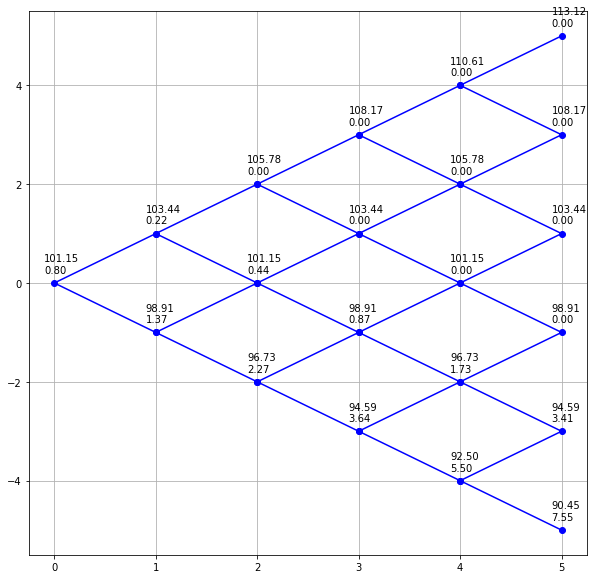

In [219]:
if N <= 10:
    m      = result[0]
    o      = result[1]
    labels = []
    for j in range(0,m.shape[0]):
        for i in range(0,j+1):
            labels.append(str("%.2f" % m[i,j]) + '\n' + str("%.2f" % o[i,j]))

    binomial_tree(N, labels)        

### Convergence Rate ###

When using binomial trees, errors may occur if only a few periods are used. This is
because a binomial tree will only produce one more leaf node (or potential outcome) than the
number of periods used, when infinite outcomes are actually possible. By increasing the number
of periods, we create more possible outcomes that are distributed more continuously.

In [220]:
nn         = range(10,1025,25)
opt_bs     = BlackScholes(-1, S0, K, r, 0.0, sigma, T)
price_bs   = [opt_bs for S in nn]
price_tree = []
for k in nn:
    sys.stdout.write("\r" + 'iter nr : ' + str(k))
    sys.stdout.flush()
    price_tree.append(binomial_model_european(k, S0, sigma, r, K, T)[1][0][0])

iter nr : 1010

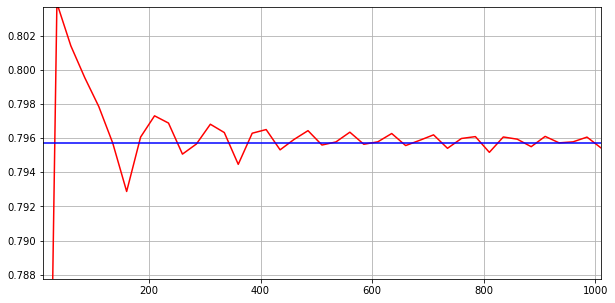

In [221]:
%matplotlib inline

fig = pl.figure(figsize=[10, 5])

pl.xlim(min(nn),max(nn))
pl.ylim(.99 * opt_bs, 1.01 * opt_bs)
pl.plot(nn, price_tree, color='r')
pl.plot(nn, price_bs,   color='b')
pl.grid()
pl.show()


A simple trick to improve convergence behaviour 

In [222]:
nn         = range(10,1025,25)
opt_bs     = BlackScholes(-1, S0, K, r, 0.0, sigma, T)
price_bs   = [opt_bs for S in nn]
price_tree = []
for k in nn:
    sys.stdout.write("\r" + 'iter nr : ' + str(k))
    sys.stdout.flush()
    price_1 = binomial_model_european(k, S0, sigma, r, K, T)[1][0][0]
    price_2 = binomial_model_european(k + 1, S0, sigma, r, K, T)[1][0][0]
    price_tree.append(0.5*(price_1+price_2))

iter nr : 1010

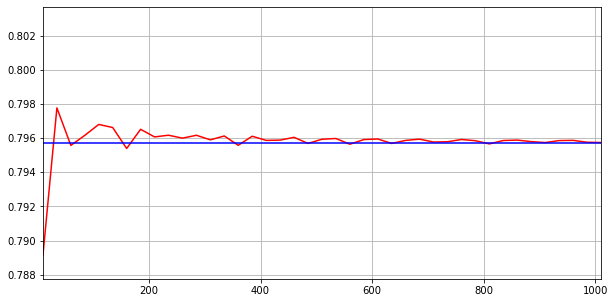

In [223]:
%matplotlib inline

fig = pl.figure(figsize=[10, 5])

pl.xlim(min(nn),max(nn))
pl.ylim(.99 * opt_bs, 1.01 * opt_bs)
pl.plot(nn, price_tree, color='r')
pl.plot(nn, price_bs,   color='b')
pl.grid()
pl.show()

###  Option on Stocks Paying a Continuous Dividend Yield

Consider a stock paying a known dividend yield at rate $q$. The total return from dividends and capital gains in a risk-neutral world is $r$. The dividends provide a return of $q$. Capital gains must therefore provide a return of $r - q$. If the stock starts at $S_0$, its expected value after one time step of length $\Delta t$ must be $S_0 e^{(r-q)\Delta t}$. This means that

$$
p \cdot S_0 \cdot u + (1-p) \cdot S_0 \cdot d = S_0 e^{(r-q)\Delta t}
$$

so that

\begin{equation}
p = \frac{e^{(r-q)\Delta t} - d}{u - d}
\end{equation}

As in the case of options on non-dividend-paying stocks, we match volatility by setting $u = e^{\sigma \sqrt{\Delta t}}$ and $d = 1/u$. This means that we can use the same equations as before except that we sobstitute $r$ with $r - q$.


### Greek Letters

#### Delta

It will be recalled that the delta $\Delta$ of an option is the rate of change of its price with respect to the underlying stock price. It can be calculated as

$$
\frac{\Delta f}{\Delta S}
$$

where $\Delta S$ is a small change in the asset price and $\Delta f$ is the corresponding small change
in the option price. At time $\Delta t$, we have an estimate $f_{1,1}$ for the option price when the
asset price is $S_0 \cdot u$ and an estimate $f_{1,0}$ for the option price when the asset price is $S_0 \cdot d$.
This means that, when $\Delta S = S_0(u - d)$, $\Delta f = f_{1,1} - f_{1,0}$. Therefore an estimate of
delta at time $\Delta t$ is

\begin{equation}
\Delta \sim \frac{f_{1,1} - f_{1,0}}{S_0(u - d)}
\end{equation}

#### Gamma

To determine gamma ($\Gamma$) note that we have two estimates of $\Delta$ at time $2 \Delta t$. When $S = (S_0 u^2 + S_0)/2$ (halfway between the second and third node), delta is 
$(f_{2,2} - f_{2,1})/(S_0 u^2 - S_0)$. When $S = (S_0 + S_0d^2)/2$ (halfway between the first and second node), delta is $(f_{2,1} - f_{2,0})/(S_0 + S_0d^2)$. The difference between the two values of $S$ is $h$ where

$$
h = \frac{1}{2} \left( S_0 u^2 - S_0 d^2 \right)
$$

Gamma is the change in delta divided by $h$:

\begin{equation}
\Gamma \sim \frac{\left[(f_{2,2} - f_{2,1})/(S_0 u^2 - S_0) \right] - \left[(f_{2,1} - f_{2,0})/(S_0 + S_0d^2) \right]}{h}
\end{equation}

These procedures provide estimates of delta at time $\Delta t$ and of gamma at time $2\Delta t$. In practice, they are usually used as estimates of delta and gamma at time zero as well.

#### Theta
A further hedge parameter that can be obtained directly from the tree is theta ($\Theta$).
This is the rate of change of the option price with time when all else is kept constant.
The value of the option at time zero is $f_{0,0}$ and at time $2\Delta t$ it is $f_{2,1}$. An estimate of
theta is therefore

\begin{equation}
\Theta \sim \frac{f_{2,1} - f_{0,0}}{2 \Delta t}
\end{equation}

#### Vega

Vega can be calculated by making a small change, $\Delta \sigma$, in the volatility and constructing
a new tree to obtain a new value of the option. (The number of time steps should be
kept the same.) The estimate of vega is

\begin{equation}
\mathcal{V} = \frac{f^\star - f}{\Delta \sigma}
\end{equation}

where $f$ and $f^\star$ are the estimates of the option price from the original and the new tree, respectively. Rho can be calculated similarly

### American Options ###

The method used to evaluate an American style derivative is very similar to that for the European option except that it is necessary to incorporate the early exercise feature. In the case of American options the value of the option at any node in the binomial tree is the greater between the value calculated by backward induction (the **continuation value**) and the payoff from early exercise. Specifically at time $t$ and node $i$ 

\begin{equation}
c_t^i = max \left[ 
max \left(K - S_t^i,o \right),  
e^{-rt}\left(p c_{t+1}^u + (1-p)c^d_{t+1}\right) 
\right]
\end{equation}

This is repeated until you return to the final node at the present time. This final node is the price of your options contract.

In [224]:
def binomial_model_american(N, S0, sigma, r, K, Maturity, opt_type = 'put'):
    """
    N      = number of binomial iterations
    S0     = initial stock price
    sigma  = factor change of upstate
    r      = risk free interest rate per annum
    K      = strike price
    """
    delta_t     = Maturity/float(N)
    discount    = exp(-r*delta_t)
    u           = exp(sigma*sqrt(delta_t))
    d           = 1 / u
    p           = (exp(r*delta_t)- d) / (u - d)
    q           = 1 - p

    # make stock price tree
    stock = np.zeros([N + 1, N + 1])
    for i in range(N + 1):
        for j in range(i + 1):
            stock[j, i] = S0 * (u ** (i - j)) * (d ** j)

    # Generate option prices recursively
    option = np.zeros([N + 1, N + 1])
    if opt_type  == 'put':
        option[:, N] = np.maximum(np.zeros(N + 1), (K - stock[:, N]))
    else:
        option[:, N] = np.maximum(np.zeros(N + 1), (stock[:, N]) - K)
        
    for i in range(N - 1, -1, -1):
        for j in range(0, i + 1):
            option[j, i] = (
                discount * (p * option[j, i + 1] + q * option[j + 1, i + 1])
            )
            #
            # dealing with early exercise
            #
            if opt_type == 'put':
                exercise     = np.maximum(0, K - stock[j, i])  
            else:
                exercise     = np.maximum(0, stock[j, i] - K)
                
            option[j, i] = np.maximum(exercise, option[j, i])

    return [stock, option]

In [226]:
result = binomial_model_american(N, S0, sigma, r, K, T, 'put')

print('Option price (binomial tree): ', result[1][0][0])

opt_bs = BlackScholes('P', S0, K, r, 0, sigma, T)
print('Option price (analytic)     : ', opt_bs)

Option price (binomial tree):  0.8006738876025329
Option price (analytic)     :  0.7957202919380961


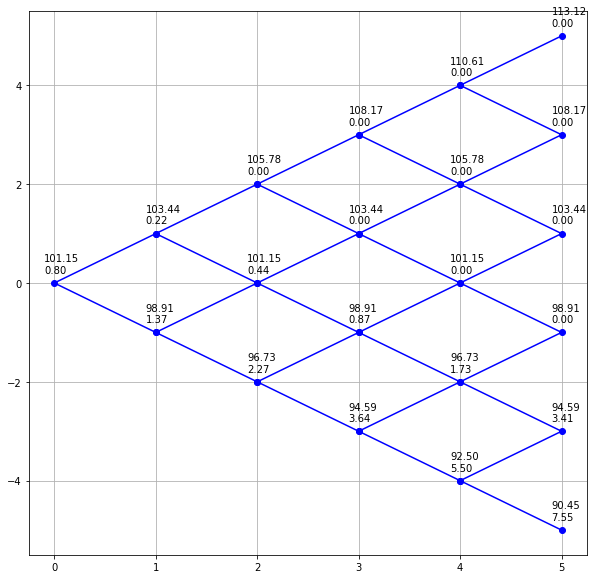

In [227]:
if N <= 10:
    m      = result[0]
    o      = result[1]
    labels = []
    for j in range(0,m.shape[0]):
        for i in range(0,j+1):
            labels.append(str("%.2f" % m[i,j]) + '\n' + str("%.2f" % o[i,j]))

    binomial_tree(N, labels)     

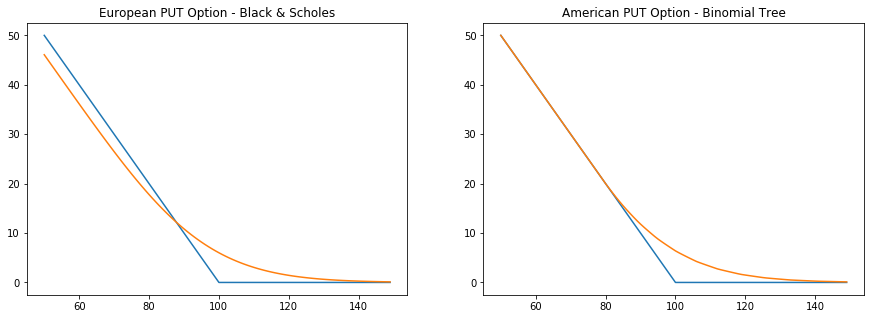

In [228]:
K     = 100.0   # strike price
T     =   1     # time-to-maturity
r     =   0.04  # short rate
sigma =   0.20  # volatility
delta =   0.0   # dividend yield

S      = np.arange(50, 150, 1.0)
PE     = BlackScholes(-1, S, K, r, delta, sigma, T)
PA     = [binomial_model_american(50, s, sigma, r, K, T)[1][0][0] for s in S]
payP   = np.maximum(K-S,0)

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title('European PUT Option - Black & Scholes')
plt.plot(S,payP)
plt.plot(S,PE)

plt.subplot(122)
plt.title('American PUT Option - Binomial Tree')
plt.plot(S,payP)
plt.plot(S,PA)


### The Leisen-Reimer Binomial Tree

In [229]:
from numpy import sign

In [230]:
def binomial_model_european_LR(N, S0, sigma, r, K, T, method, opt_type = 'put'):
    """
    N      = number of binomial levels
    S0     = initial stock price
    sigma  = factor change of upstate
    r      = risk free interest rate per annum
    K      = strike price
    """
    if N % 2 == 0: N = N + 1

    dt       = T / N
    discount = exp(-r * dt)

    # Leisen-Reimer Tree Parameters

    d1 = (log(S0 / K) + (r + sigma ** 2 / 2) * T) / sigma / sqrt(T)     # D Plus
    d2 = (log(S0 / K) + (r - sigma ** 2 / 2) * T) / sigma / sqrt(T)     # D Minus

    u_n = exp( sigma * sqrt(dt))
    d_n = exp(-sigma * sqrt(dt))
    r_n = exp(r * dt)

    term1 = (d1 / (N + 1 / 3.0 - (1 - method) * 0.1 / (N + 1))) ** 2 * (N + 1 / 6)
    pp = 0.5 + sign(d1) * 0.5 * sqrt(1 - exp(-term1))

    term1 = (d2 / (N + 1 / 3 - (1 - method) * 0.1 / (N + 1))) ** 2 * (N + 1 / 6)
    p = 0.5 + sign(d2) * 0.5 * sqrt(1 - exp(-term1))
    q = 1 - p
    #
    u = r_n * pp / p
    d = (r_n - p * u) / (1 - p)
    #
    # make stock price tree
    # 
    stock = np.zeros([N + 1, N + 1])
    for i in range(N + 1):
        for j in range(i + 1):
            stock[j, i] = S0 * (u ** (i - j)) * (d ** j)
    #
    # Initialize option matrix 
    #
    option = np.zeros([N + 1, N + 1])
    # 
    # Generate option prices recursively
    #
    #
    # We start from the maturity (the binomial tree is a backward 
    # in time algorithm remember?). At maturity we know the value 
    # of the option in all states, it is simply the payoff. In this
    # case the payoff is that of a put option.
    #
    if opt_type == 'put':
        option[:, N] = np.maximum(np.zeros(N + 1), (K - stock[:, N]))
    else:
        option[:, N] = np.maximum(np.zeros(N + 1), (stock[:, N]) - K)
        
    for i in range(N - 1, -1, -1):
        for j in range(0, i + 1):
            option[j, i] = (
                discount * (p * option[j, i + 1] + q * option[j + 1, i + 1])
            )
    return [stock, option]

In [231]:
result = binomial_model_european_LR(N, S0, sigma, r, K, T, 2) 
print('Option price (binomial tree): ', round(result[1][0][0],3))
opt_bs = BlackScholes(-1, S0, K, r, 0.0, sigma, T)
print('Option price (analytic)     : ', round(opt_bs,3))

Option price (binomial tree):  5.566
Option price (analytic)     :  5.577


In [232]:
nn         = range(1,250,1)
opt_bs     = BlackScholes(-1, S0, K, r, 0.0, sigma, T)
price_bs   = [opt_bs for S in nn]
price_tree = []
for k in nn:
    sys.stdout.write("\r" + 'iter nr : ' + str(k))
    sys.stdout.flush()
    price_tree.append(binomial_model_european_LR(k, S0, sigma, r, K, T, 2)[1][0][0])

iter nr : 249

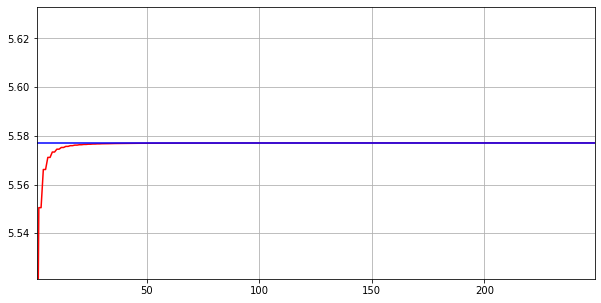

In [233]:
%matplotlib inline

fig = pl.figure(figsize=[10, 5])

pl.xlim(min(nn),max(nn))
pl.ylim(.99 * opt_bs, 1.01 * opt_bs)
pl.plot(nn, price_tree, color='r')
pl.plot(nn, price_bs,   color='b')
pl.grid()
pl.show()


# Trinomial Trees

Under the trinomial method, the underlying stock price is modeled as a recombining tree, where, at each node the price has three possible paths: an up, down and stable or middle path.

These values are found by multiplying the value at the current node by the appropriate factor $u$, $d$ or $m$ where

$$
u = e^{\sigma \sqrt{2 \Delta t}}, \> d = e^{-\sigma \sqrt{2 \Delta t}}, \>m = 1
$$

and the corresponding probability are:

$$
 p_u = \left(\frac{e^{(r - q)  \Delta t / 2}- e^{-\sigma\sqrt {\Delta t/2}}}{e^{\sigma\sqrt {\Delta t/2}}- e^{-\sigma\sqrt {\Delta t/2}}}\right)^2 ,\quad
p_d = \left(\frac{e^{\sigma\sqrt {\Delta t/2}}-e^{(r - q)  \Delta t / 2}}{e^{\sigma\sqrt {\Delta t/2}}- e^{-\sigma\sqrt {\Delta t/2}}}\right)^2
$$
and $p_m = 1 - (p_u + p_d)$

As with the binomial model, these factors and probabilities are specified so as to ensure that the price of the underlying evolves as a martingale, while the moments are matched to those of the log-normal distribution. Note that for $p_u$ , $p_d$ and $p_m$  to be in the interval $(0,1)$ the following condition on $\Delta t$  has to be satisfied:

$$
 \Delta t < 2\frac{\sigma^2}{(r-q)^2} .
$$

In [234]:
from math import exp, sqrt
import numpy as np

In [250]:
c     = -1   # c = 1 for a call, = -1 for a put 
T     = 1
n     = 5
r     = 0
K     = 100
sigma = 0.05
s0    = 101.15

In [251]:
s = np.zeros([2*(n + 1), n + 1])
o = np.zeros([2*(n + 1), n + 1])

In [252]:
dt  = T / n

Df = exp(-r * dt)

u  = exp(sigma * sqrt(2 * dt))
d  = exp(-sigma * sqrt(2 * dt))

dt2 = dt/2.0
sdt2 = sigma * sqrt(dt2)

pu = ((exp(r * dt2) - exp(-sdt2)) / (exp(sdt2) - exp(-sdt2))) ** 2
pd = ((exp(sdt2) - exp(r * dt2)) / (exp(sdt2) - exp(-sdt2))) ** 2
pm = 1 - pu - pd

Now we set the final condition at expiration

In [253]:
for k in range(2*n + 1):
    s[k, n] = s0 * u ** max(k - n, 0) * d ** max(n * 2 - n - k, 0)
    o[k, n] = max(c*(s[k, n] - K), 0.0)

In [254]:
shape(s)

(12, 6)

Calcolation loop

In [255]:
for j in range(n - 1, -1, -1):
    for i in range(2*j + 1):
        s[i, j] = s0 * u ** max(i - j, 0) * d ** max(j * 2 - j - i, 0)
        o[i, j] = (pu * o[i + 2, j + 1] + pm * o[i + 1, j + 1] + pd * o[i, j + 1]) * Df

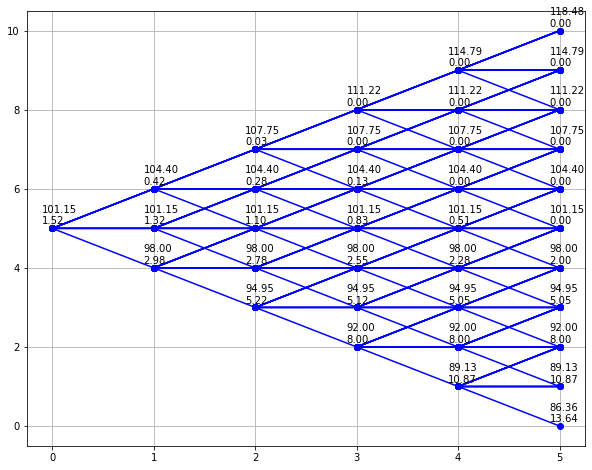

In [256]:
if n < 10:
    labels = []
    for x in range(0, n + 1):
        npoints = 3 * x - x + 1
        for y in range(npoints - 1, -1, -1):
            labels.append(str("%.2f" % s[y, x]) + '\n' + str("%.2f" % o[y, x]))

    trinomial_tree(n, labels)     

Comparing results

In [244]:
result = binomial_model_european(n, s0, sigma, r, K, T) 
blsh_price = BlackScholes(-1, s0, K, r, 0, sigma, T)
trtr_price = o[0,0]
bitr_price = result[1][0][0]

print("Option Price (Black and Scholes) = %s" % str(round(blsh_price,4)))
print("Option price (Binomial tree)     = %s" % str(round(bitr_price,4)))
print("Option Price (Trinomial Tree)    = %s" % str(round(trtr_price,4)))

Option Price (Black and Scholes) = 1.4832
Option price (Binomial tree)     = 1.4974
Option Price (Trinomial Tree)    = 1.4816


In [245]:
def trinomial_model_european(n, s0, sigma, r, K, T, opt_type = 'put'):
    '''
        Description
    '''
    c = -1
    if opt_type == 'call': c = 1
    #
    # Initialize stock and option matrices
    #
    s = np.zeros([2*(n + 1), n + 1])
    o = np.zeros([2*(n + 1), n + 1])    
    #
    # Calculation of transition probabilities
    #
    dt   = T / n
    Df   = exp(-r * dt)
    #
    u    = exp(sigma * sqrt(2 * dt))
    d    = exp(-sigma * sqrt(2 * dt))
    #
    dt2  = dt/2.0
    sdt2 = sigma * sqrt(dt2)
    #
    pu   = ((exp(r * dt2) - exp(-sdt2)) / (exp(sdt2) - exp(-sdt2))) ** 2
    pd   = ((exp(sdt2) - exp(r * dt2)) / (exp(sdt2) - exp(-sdt2))) ** 2
    pm   = 1 - pu - pd
    #
    # Setting final conditions
    #
    for k in range(2*n + 1):
        s[k, n] = s0 * u ** max(k - n, 0) * d ** max(n * 2 - n - k, 0)
        o[k, n] = max(c*(s[k, n] - K), 0.0)
    #
    # Calculation loop
    #
    for j in range(n - 1, -1, -1):
        for i in range(2*j + 1):
            s[i, j] = s0 * u ** max(i - j, 0) * d ** max(j * 2 - j - i, 0)
            o[i, j] = (pu * o[i + 2, j + 1] + pm * o[i + 1, j + 1] + pd * o[i, j + 1]) * Df
            
    return o[0, 0]        

### Convergence Rate

In [246]:
nn         = range(10,1000,5)
opt_bs     = BlackScholes(-1, S0, K, r, 0.0, sigma, T)
price_bs   = [opt_bs for S in nn]
price_tree = []
for k in nn:
    sys.stdout.write("\r" + 'iter nr : ' + str(k))
    sys.stdout.flush()
    price_tree.append(trinomial_model_european(k, s0, sigma, r, K, T))

iter nr : 995

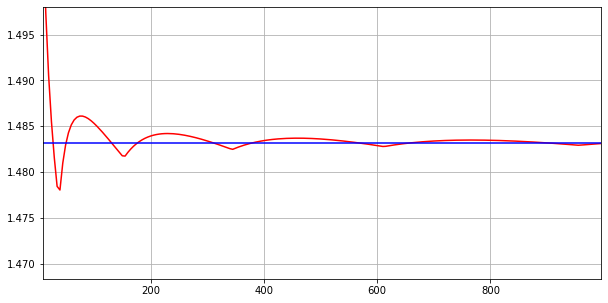

In [247]:
%matplotlib inline

fig = pl.figure(figsize=[10, 5])

pl.xlim(min(nn),max(nn))
pl.ylim(.99 * opt_bs, 1.01 * opt_bs)
pl.plot(nn, price_tree, color='r')
pl.plot(nn, price_bs,   color='b')
pl.grid()
pl.show()

# References #

*Paul Wilmott*, **Derivatives, The Theory and Practice of Financial Engineering**, University Edition

*Paul Wilmott, Sam Howison and Jeff Dewinne*, **The Mathematics of Financial Derivatives, A Student Introduction**, Cambridge University Press

*John C. Hull*, **Option, Futures and Other Derivatives**, 6th Edition, Prentice Hall
